# LSTM on real DNA sequences

# Leggi qui
Nella parte prima di START HERE ho commentato le linee che non servono più perché ho già generato i file necessari, che puoi trovare nella mia cartella /ubuntu (non dovrebbero esserci problemi di permessi). 

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# START HERE

Qui il codice commentato è perché volevo fare un po' di prove, quindi può essere cambiato a piacimento

Attenzione perché la rete così com'è ci mette tanto ad allenarsi.

In [4]:
intr_file = '../data/hg19_intr_clean.fa'
depl_file = '../data/hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    for j in range(n_jumps):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 10
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [5]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

733640

In [7]:
print(merge_texts[0][0])

G


In [7]:
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

733640


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X)
print('\n')
print(X.shape)

[[153634 568397 382160 ... 635443 506832 658088]
 [568397 382160 380712 ... 506832 658088 654350]
 [382160 380712 323461 ... 658088 654350 503434]
 ...
 [  1173    900    397 ...  64841  93299 115195]
 [   900    397    537 ...  93299 115195 135311]
 [   397    537   1117 ... 115195 135311  63747]]


(733640, 191)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [10]:
print(X_train.shape)
print(X_test.shape)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(586912, 191)
(146728, 191)


In [12]:
max_length = max([len(s.split()) for s in merge_texts])
print(max_length)

191


In [13]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

944238


In [15]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 10)) #dropout = 0.2 #input_length = max_length
#model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(LSTM(10)) #dropout = 0.2, recurrent_dropout = 0.2
model.add(Bidirectional(LSTM(10))) #dropout = 0.2, recurrent_dropout = 0.2
#model.add(Bidirectional(SimpleRNN(10)))
#model.add(GRU(10))
#model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))
#model.add(Flatten())
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0001), metrics = ['accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          9442380   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1680      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 469529 samples, validate on 117383 samples
Epoch 1/5
469529/469529 [==============================] - 1922s 4ms/sample - loss: 0.2456 - accuracy: 0.8789 - val_loss: 0.0707 - val_accuracy: 0.9726
Epoch 2/5
469529/469529 [==============================] - 1910s 4ms/sample - loss: 0.0248 - accuracy: 0.9912 - val_loss: 0.0316 - val_accuracy: 0.9891
Epoch 3/5
469529/469529 [==============================] - 1900s 4ms/sample - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0234 - val_accuracy: 0.9938
Epoch 4/5
469529/469529 [==============================] - 1919s 4ms/sample - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0225 - val_accuracy: 0.9961
Epoch 5/5
469529/469529 [==============================] - 1940s 4ms/sample - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0377 - val_accuracy: 0.9967


Confusion matrix:
 [[73108   250]
 [  236 73134]]


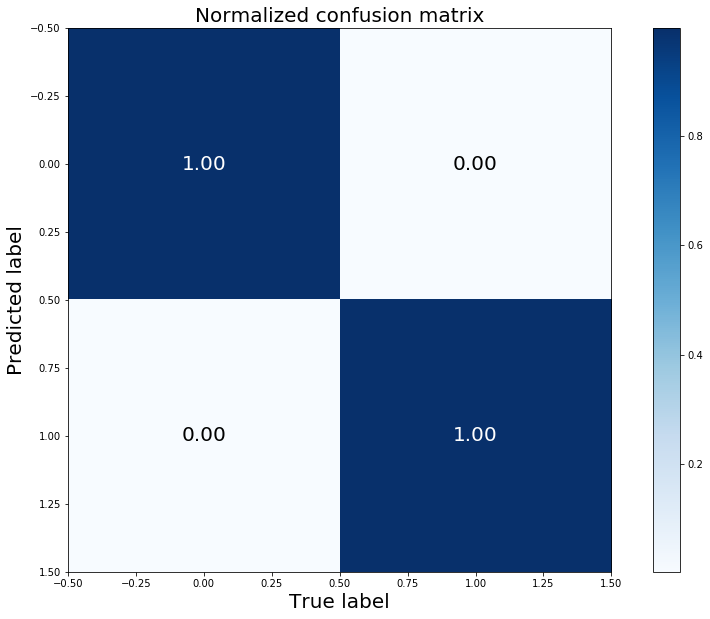

In [17]:
plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [18]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 99.67%
